# AIPI 590 - XAI | Assignment #05
### Explainable Deep Learning
### Rebecca Du (rrd17)



[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rrdu/AIPI-590/blob/main/HW5/AIPI590_ExplainableDL.ipynb)


## Overview

For this assignment, we were tasked with using a pretrained deep learning (DL) model to investigate explainability in computer vision.

The model and dataset I chose are listed below:

- **Model**: ResNet50
- **Dataset**: [Oxford-IIIT Pet Dataset](https://www.kaggle.com/datasets/tanlikesmath/the-oxfordiiit-pet-dataset)
- **Explainability Techniques**: GradCAM, GradCAM++, XGradCAM

*Note: AI was used in this assignment. Instances where it was used are cited in the appropriate cells.

The steps I will take are as follows:

1. Load Dataset
2. Load and Test ResNet50 Model
3. Run GradCAM Methods
    - 3.1) GradCAM
    - 3.2) GradCAM++
    - 3.3) XGradCAM
4. GradCAM Comparative Analysis
5. Reflection

## 1) Load Dataset

For this assignment, the goal is to assess and use explainability techniques to investigate the performance of the ResNet50 model on detecting different animals.

First, we will load in the dataset.


In [ ]:
!pip install grad-cam

In [ ]:
#Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import random
import kagglehub

from google.colab import files
from PIL import Image

import torch, torchvision as tv
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torchvision.models import ResNet50_Weights
from torch.utils.data import Dataset, DataLoader, random_split

#GradCAMs
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [ ]:
#Download dataset
root = './data'

#Raw dataset
raw_dataset = dataset = OxfordIIITPet(root, split='test', target_types='category',
                        download=True)

In [ ]:
#Look at the classes
print(len(dataset.classes), 'Classes')

37 Classes


In [ ]:
print(dataset.classes[:5])

['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle']


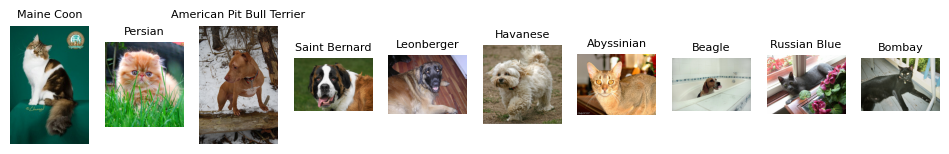

In [ ]:
#Sample a few random images
random_indexes = random.sample(range(len(dataset)), 10)
random_imgs = [dataset[i] for i in random_indexes]

fig, axes = plt.subplots(1, len(random_imgs), figsize = (12, 6))
for ax, (img, label) in zip(axes, random_imgs):
  ax.imshow(img)
  ax.set_title(dataset.classes[label], fontsize=8)
  ax.axis('off')
plt.show()

Looks like there's a good array of cute animals here - mostly different breeds of cats and dogs.

Now, let's preprocess the dataset for the model.

In [ ]:
#Preprocessed dataset
weights = ResNet50_Weights.IMAGENET1K_V2
transform = weights.transforms()

In [ ]:
#Make train and test datasets
train_dataset = OxfordIIITPet(root="./data", split="trainval", target_types="category", download=True, transform=transform)
test_dataset  = OxfordIIITPet(root="./data", split="test", target_types="category", download=True, transform=transform)

## 2) Load ResNet 50 Model

ResNet50 is a convolutional neural network trained for image classification.

Here we will apply it to our dataset.

In [ ]:
#Load in pretrained ResNet50
device = 'cuda' if torch.cuda.is_available() else 'cpu'

weights = ResNet50_Weights.IMAGENET1K_V2
model = tv.models.resnet50(weights=weights).to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 111MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#Replace classifier so that it works for the 37 classes
model.fc = torch.nn.Linear(model.fc.in_features, 37).to(device)

In [ ]:
img, label = test_dataset[0]
x = img.unsqueeze(0).to(device)

with torch.inference_mode():
    logits = model(x)
    pred = logits.argmax(1).item()

print("Predicted:", train_dataset.classes[pred])
print("True:", train_dataset.classes[label])

Predicted: Bengal
True: Abyssinian


Unfortunately, it looks like ResNet50 is not the best at predicting different breeds since it has not been finetuned on this dataset.

Let's go forward with performing GradCAM to see if we can understand why it misclassified these images.

## 3) GradCAM Methods:

[GradCAM](https://jacobgil.github.io/pytorch-gradcam-book/introduction.html) is a deep learning explainability technique specific to vision models. It uses a heatmap to highlight the areas of an image that the model "looks" at to decide what the ultimate label will be.

We will implement the following GradCAM Methods:
1) **GradCAM (standard)**
2) **GradCAM++**: an enhanced version of GradCAM that uses pixel-wise gradient weights, making it better at handling images with multiple occurrences of something.
3) **XGradCAM**: scales the gradients by the normalized activations, making outputs less noisy.

### 3.1) GradCAM

In [ ]:
#Create raw test dataset to display images
raw_test_dataset = OxfordIIITPet(root, split='test', target_types='category',
                                 download=True, transform=None)

In [ ]:
#Select target layer
target_layer = model.layer4[-1].conv3

In [ ]:
#Code below generated using GPT-5 on 10/3/2025 at 5:08 PM
#Capture activations and gradients at the target layer
_acts = _grads = None
def _fwd_hook(_, __, out):
  global _acts
  _acts = out.detach()

def _bwd_hook(_, grad_in, grad_out):
  global _grads
  _grads = grad_out[0].detach()

#Register hooks
h1 = target_layer.register_forward_hook(_fwd_hook)
h2 = target_layer.register_full_backward_hook(_bwd_hook)
#End of generated code
#Link to chat: https://chatgpt.com/share/68e03cbe-3090-8013-a73c-e17e980f7733

In [ ]:
#The function below was generated using GPT-5 on 10/3/2025 at 5:13 PM
def gradcam_single(x, class_idx=None, mode='gradcam', eps=1e-8):
  global _acts, _grads
  _acts = _grads = None

  logits = model(x)  #Forward stores _acts via hook
  if class_idx is None:
      class_idx = int(logits.argmax(1).item())

  model.zero_grad(set_to_none=True)
  logits[0, class_idx].backward()  #Populates _grads via hook

  A = _acts                  # [1, C, Hc, Wc]
  G = _grads                 # [1, C, Hc, Wc]

  if mode == 'gradcam':
    #w_k = GAP of grads
    w = G.mean(dim=(2,3), keepdim=True)                      # [1,C,1,1]

  elif mode == 'gradcam++':
    # Grad-CAM++ weights (no higher-order autograd needed; use G^2, G^3)
    G2 = G * G
    G3 = G2 * G
    # denominator: 2*G^2 + A * sum_ij(G^3)
    sum_G3 = G3.sum(dim=(2,3), keepdim=True)                 # [1,C,1,1]
    denom = (2.0 * G2 + A * sum_G3).sum(dim=(2,3), keepdim=True)  # [1,C,1,1]
    alpha = (G2.sum(dim=(2,3), keepdim=True)) / denom               # [1,C,1,1]
    w = (alpha * F.relu(G)).sum(dim=(2,3), keepdim=True)     # [1,C,1,1]

  elif mode == 'xgradcam':
    #w_k = sum_ij (grad*act) / (sum_ij act + eps)
    num = (G * A).sum(dim=(2,3), keepdim=True)               # [1,C,1,1]
    den = (A.sum(dim=(2,3), keepdim=True).abs()) + eps             # [1,C,1,1]
    w = num / den

  cam = (w * A).sum(dim=1, keepdim=True)                   # [1,1,Hc,Wc]
  cam = F.relu(cam)
  cam = F.interpolate(cam, size=x.shape[-2:], mode="bilinear", align_corners=False)
  cam = cam[0, 0]
  cam = (cam - cam.min()) / (cam.max() + 1e-8)

  return class_idx, cam.cpu().numpy().astype(np.float32)
#End of generated code
#Link to chat: https://chatgpt.com/share/68e03cbe-3090-8013-a73c-e17e980f7733

In [ ]:
#ImageNet class names (since we did NOT fine-tune)
imagenet_names = weights.meta["categories"]
oxford_breed_names = test_dataset.classes

In [ ]:
def show_cam(idx, mode='gradcam', alpha=0.35):
  #Get model input (normalized tensor) and ground-truth label
  img_t, y = test_dataset[idx]
  x = img_t.unsqueeze(0).to(device)

  #Use Grad-CAM
  with torch.enable_grad():  # we need grads for cam
      cls, cam = gradcam_single(x, class_idx=None, mode=mode)

  # Original PIL image for display
  raw_img, _ = raw_test_dataset[idx]

  #Plot
  plt.figure(figsize=(6,6))
  plt.imshow(raw_img)                       #Original image
  plt.imshow(cam, cmap="jet", alpha=alpha)  #Heatmap
  plt.axis("off")
  plt.title(f"ImageNet Prediction: {imagenet_names[cls]}\nOxford Ground Truth: {oxford_breed_names[y]}")
  plt.show()

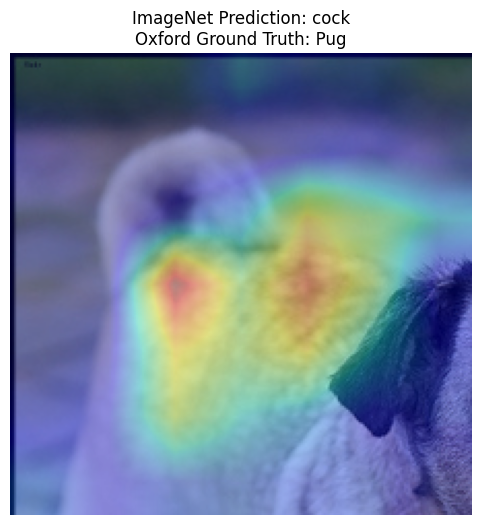

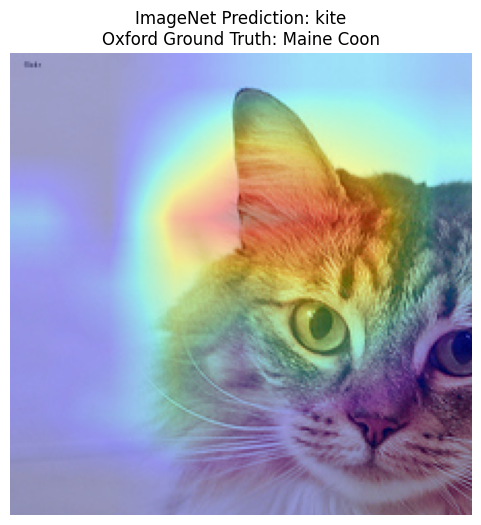

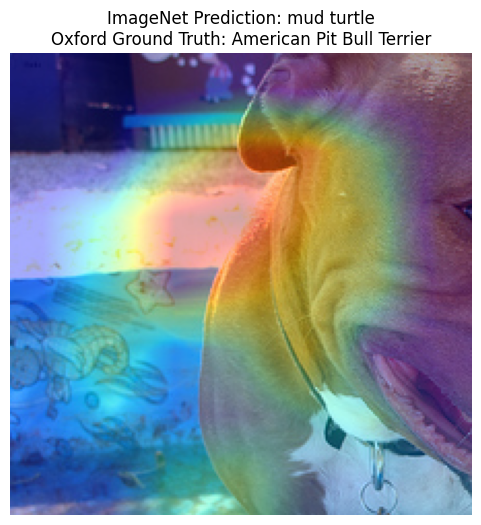

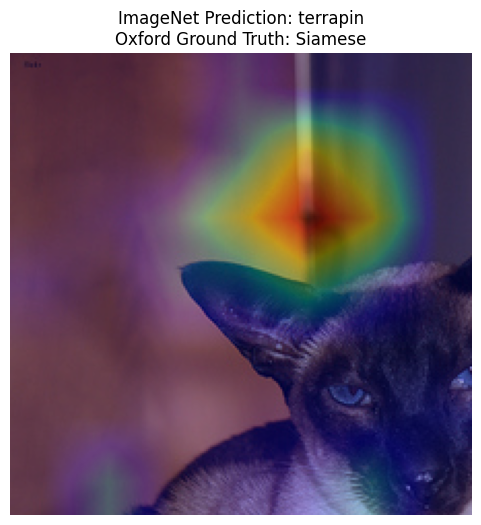

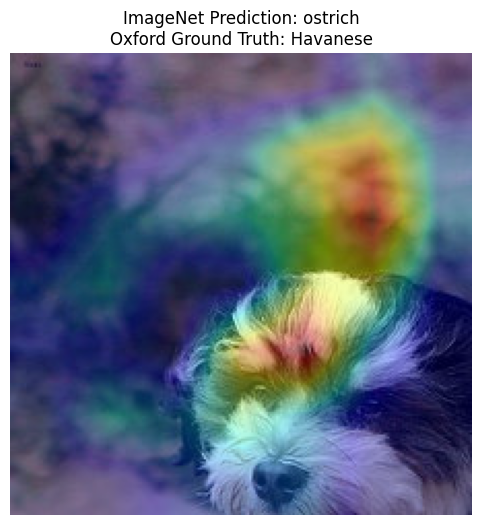

In [ ]:
#Try GradCAM on 5 images
gradcam_img_indexes = random.sample(range(len(test_dataset)), 5)
gradcam_outputs = []

for index in gradcam_img_indexes:
  gradcam_outputs.append(show_cam(index, mode='gradcam'))


### 3.2) GradCAM++

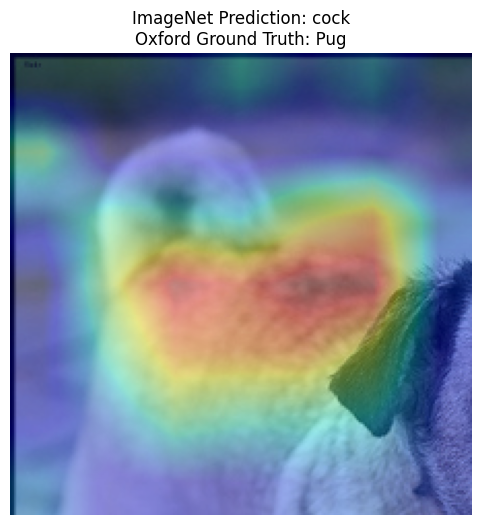

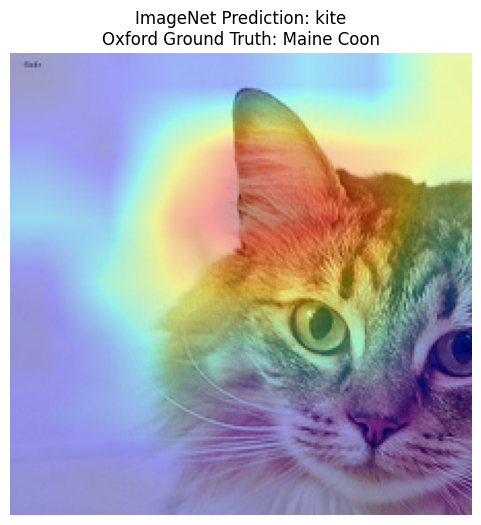

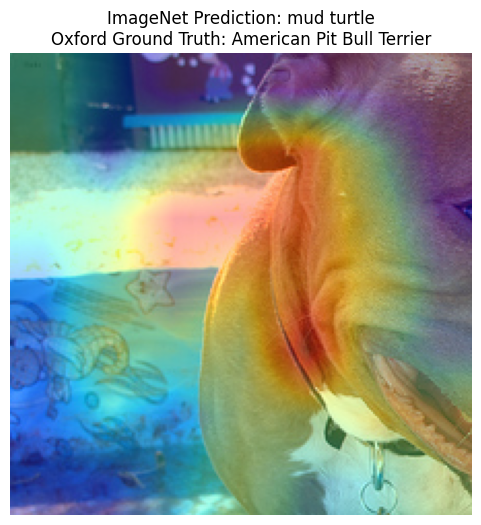

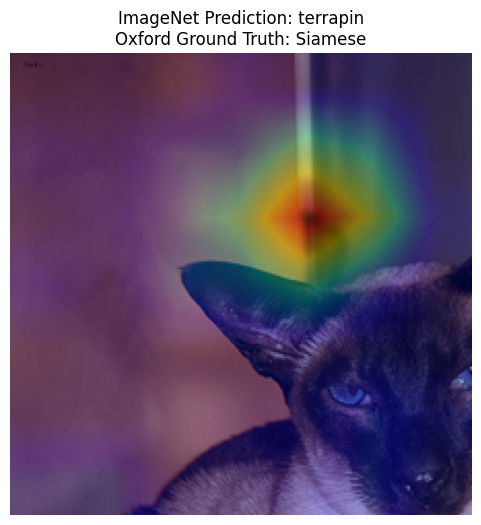

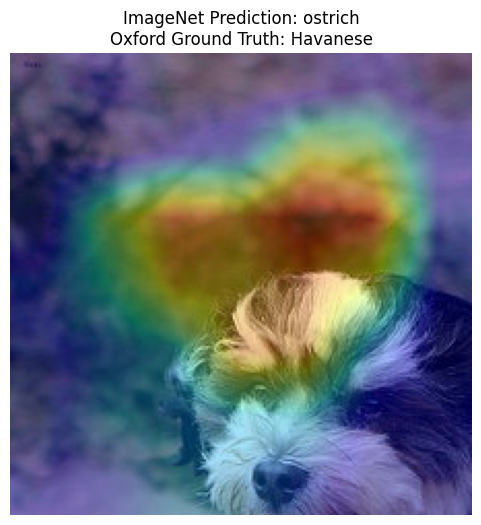

In [ ]:
#Try GradCAM++ on same 5 images
gradcampp_outputs = []

for index in gradcam_img_indexes:
  gradcampp_outputs.append(show_cam(index, mode='gradcam++'))

### 3.3) XGradCAM

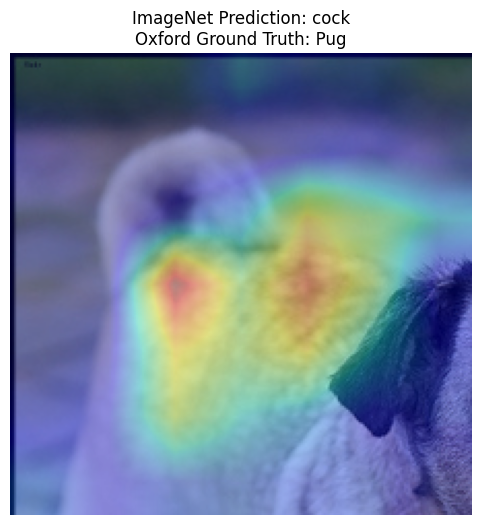

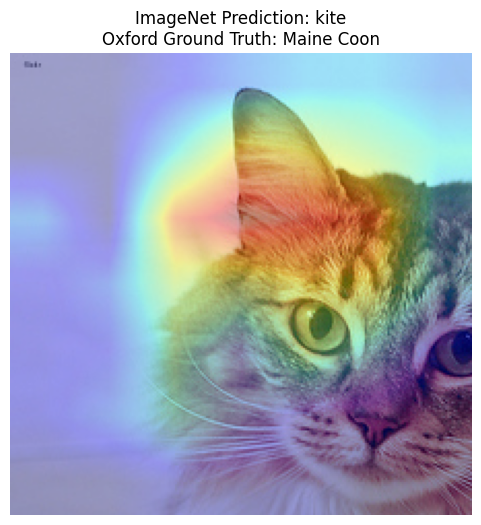

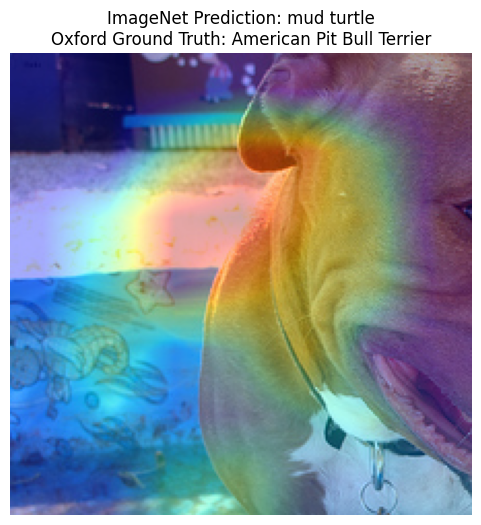

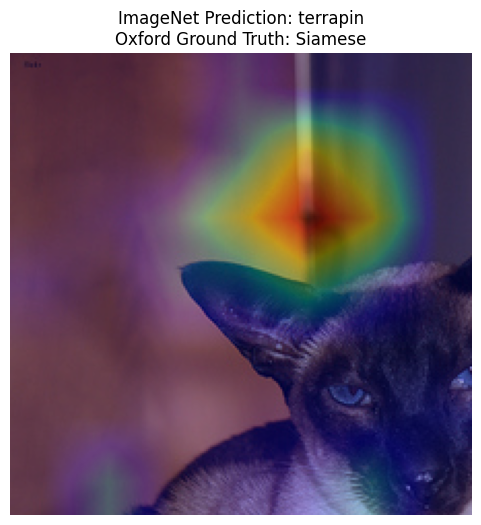

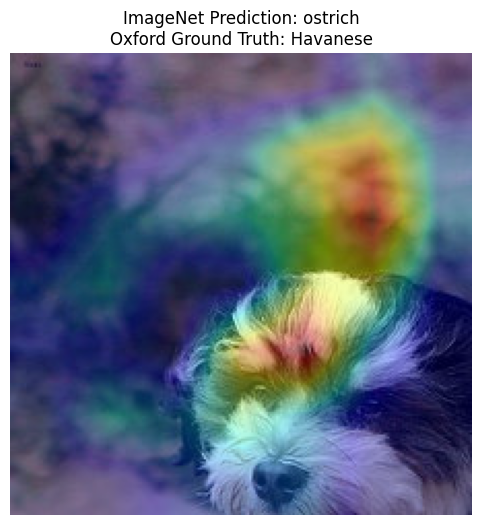

In [ ]:
#Try XGradCAM on same 5 images
xgradcam_outputs = []

for index in gradcam_img_indexes:
  xgradcam_outputs.append(show_cam(index, mode='xgradcam'))

## 4) GradCAM Comparative Analysis

The results of each GradCAM variant are depicted below.

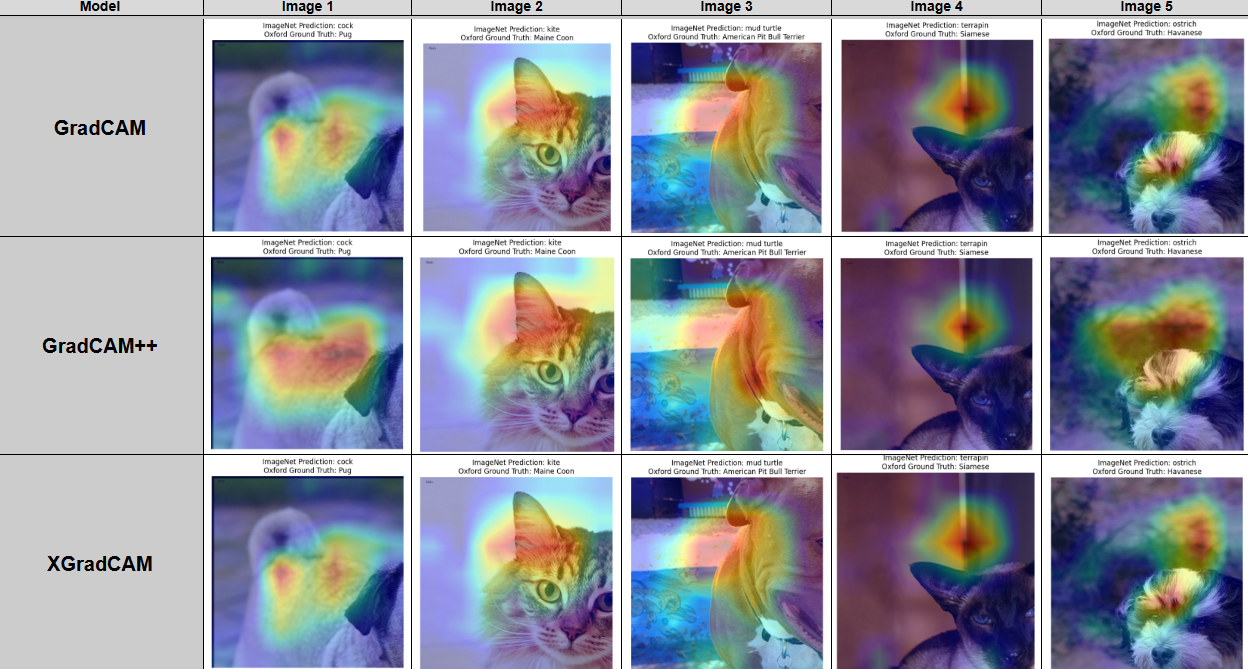

First off, ResNet50 was unable to correctly classify any of the images. This is to be expected because the Oxford IIIT Pet Breed dataset focuses on different cat and dog breeds whereas ImageNet (which ResNet50 was trained on) has a broader range of images. Since we did not finetune ResNet50 for the new dataset, it makes sense that the predictions are not accurate.

From the table above, we can see the following:
- **GradCAM**:
  - For images where the animal's face and ears are visible, the model tends to pay attention to those areas (demonstrated by the red area of the heatmap).
  - Otherwise, the attention seems to be relatively toward the center of the image.
  - The heatmaps are broad, allowing the model to take in some more details (though this may include things unrelated to the animal, such as in the case of the siamese cat).

- **GradCAM++**:
  - Again, the heatmap seems to be centered around the animal's head and ears (when visible).
  - The area is sharper than that of GradCAM's, with more emphasis on areas like the maine coon's eyes.
  - However, this focusing may be a downside that causes it to miss other key features.

- **XGradCAM**:
  - The results are very similar to that of regular GradCAM, with model focus mostly being on the animal's face (when visible), or the center of the image.
  - This makes sense because the mathematical calculation of XGradCAM is simply the average of the gradient $\times$ the activation, which is then normalized by the activation sum.
  - This is similar to the mathematical calculation for normal GradCAM, which is the average gradient.
  - Since the activations and gradients for ResNet50 are very similar for the pet images in the Oxford dataset, the normalizing power in XGradCAM is minimal, leading to a near-identical output.

Overall, we can see that the ResNet50 model was headed in the right direction - centering mostly around the animal's face/ears (the most distinctive traits differentiating one breed from another).

From the GradCAM / GradCAM++ / XGradCAM results, it seems that the model was closest on Image 2 (the Maine Coon), since the heatmap for all 3 is centered around its face.

However, the model probably struggled the most with Image 4 (the Siamese cat), as the heatmap is centered on a small area above the cat's head. This could be explained by the fact that the Siamese cat's color scheme is similar to that of the background and that it's narrowed eyes make it difficult for the model to register it as an animal's face.

## 5) Reflection

- **Visual Cues:**
  - From the GradCAM / GradCAM++ / XGradCAM visualizations, the heatmap tended to focus on the animal's face/eyes (when they were visible).
  - Logically, this would make sense, as eyes are a unique distinguishing feature that would quickly clue the model in as to what it should be focusing on in an image.
  - The model struggled a bit in images where there was no visible eyes/face (such as in Image 1 of the Pug's tail), as well as in images where the animal's face may be confused for the background (such as in Image 4 of the Siamese cat, and Image 5 of the Havanese dog).


- **Surprising/Misleading Behavior:**
  - I found it interesting that for Image 1 (Pug's tail) and Image 3 (Bull Terrier's left jowl), the model's heatmap seemed to be nearing towards crucial 'clues' that would indicate what the animal is.
  - In Image 1, it seems to be close to the tail, which might inform it that the image is of a dog.
  - In Image 3, it is very close to the Terrier's ear, or even the folds of skin on the jowls, both of which could inform the model of what the animal is.
  - From a human's perspective, that is also where I would look in a similarly cropped image to determine what type of animal is in the picture.
  - However, for other instances (such as Image 4 of the Siamese cat, or Image 5 of the Havanese dog), the model seems completely lost and preoccupied with the background.
  - This may be an indication that the model still has not truly 'learned' what qualifies as a certain type of animal and is instead simply guessing based on the background.

- **Importance of Explainability:**
  - I mostly picked this dataset because the animals in the GradCAM Github were adorable and I wanted to use a similar dataset to that.
  - However, a potential real-world application of this could be tracking lost pets.
  - From the images, it is apparent that the differences between animal breeds can be very small at times.
  - If an agency were to use a vision model to try and process pets that have been classified as lost, it would be unfortunate if they were to misclassify, say, a Pug as a Bull Terrier and accidentally return the wrong pet to the owner!
  - Using explainability techniques not only highlights the subtle differences between animal breeds, but also the need to create robust models that don't get distracted by the background of the image and can instead focus on key identifiable features of the pet breed.
  - Without explainability, it would be difficult to distinguish edge cases where the model is struggling, or to even understand how the model reaches the conclusion that it does.